## Machine Learning project

### Part 1.0:
### Exploratory data analysis/Understanding the dataset:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import shap

##### 1.1: Loading the dataset

In [2]:
data=pd.read_csv("dataset.csv")
data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,category_1,category_2,target
0,0.496714,1.146509,-0.648521,0.833005,0.784920,-2.209437,-1.300105,-2.242241,Above Average,Region C,1
1,-0.138264,-0.061846,NaN,0.403768,0.704674,-2.498565,-1.339227,-1.942298,Below Average,Region A,0
2,0.647689,1.395115,-0.764126,1.708266,-0.250029,1.956259,1.190238,1.503559,High,Region C,1
3,1.523030,2.657560,-2.461653,2.649051,0.882201,3.445638,2.120913,3.409035,High,Region B,1
4,-0.234153,-0.499391,0.576097,-0.441656,0.610601,0.211425,0.935759,-0.401463,Below Average,Region C,0


##### 1.2: Checking shape,missing values,data types,statisctics

In [3]:
print("📊 Dataset size:", data.shape)
print("\n🧾 Data types:\n", data.dtypes)
print("\n🔍 Missing values:\n", data.isnull().sum())


📊 Dataset size: (9000, 11)

🧾 Data types:
 feature_1     float64
feature_2     float64
feature_3     float64
feature_4     float64
feature_5     float64
feature_6     float64
feature_7     float64
feature_8     float64
category_1     object
category_2     object
target          int64
dtype: object

🔍 Missing values:
 feature_1       0
feature_2       0
feature_3     400
feature_4       0
feature_5       0
feature_6     500
feature_7       0
feature_8       0
category_1      0
category_2      0
target          0
dtype: int64


#### 1.3:Vizualize distributions 

In [4]:
num_features=data.select_dtypes(include=['float64','int64']).columns.tolist()
num_features.remove('target')

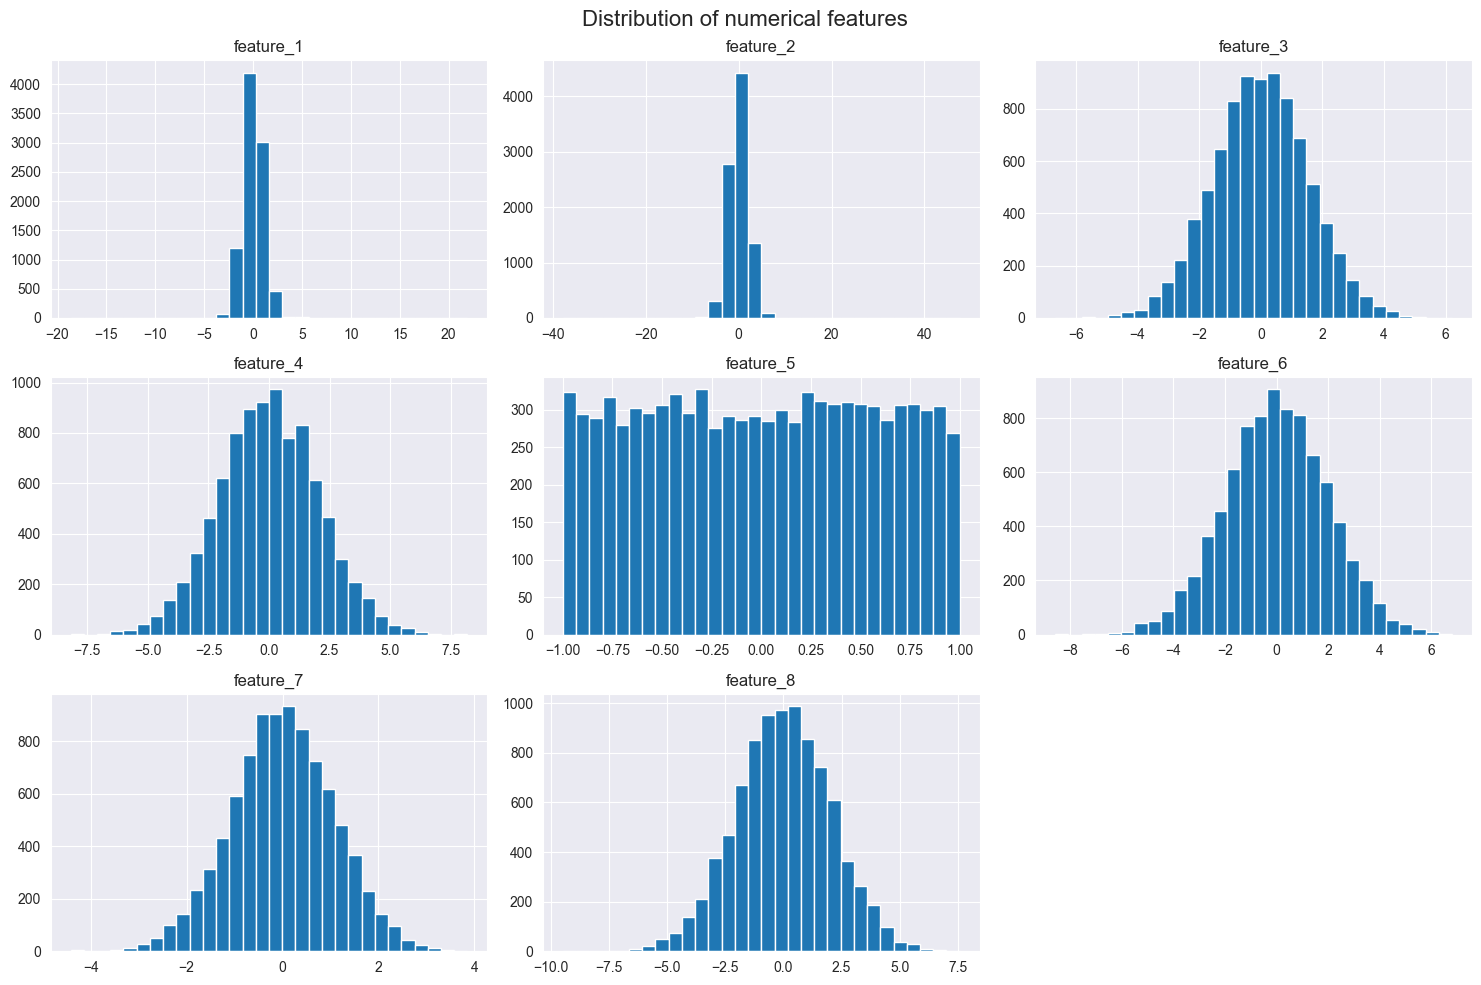

In [5]:
data[num_features].hist(bins=30, figsize=(15, 10))
plt.suptitle("Distribution of numerical features", fontsize=16)
plt.tight_layout()
plt.show()

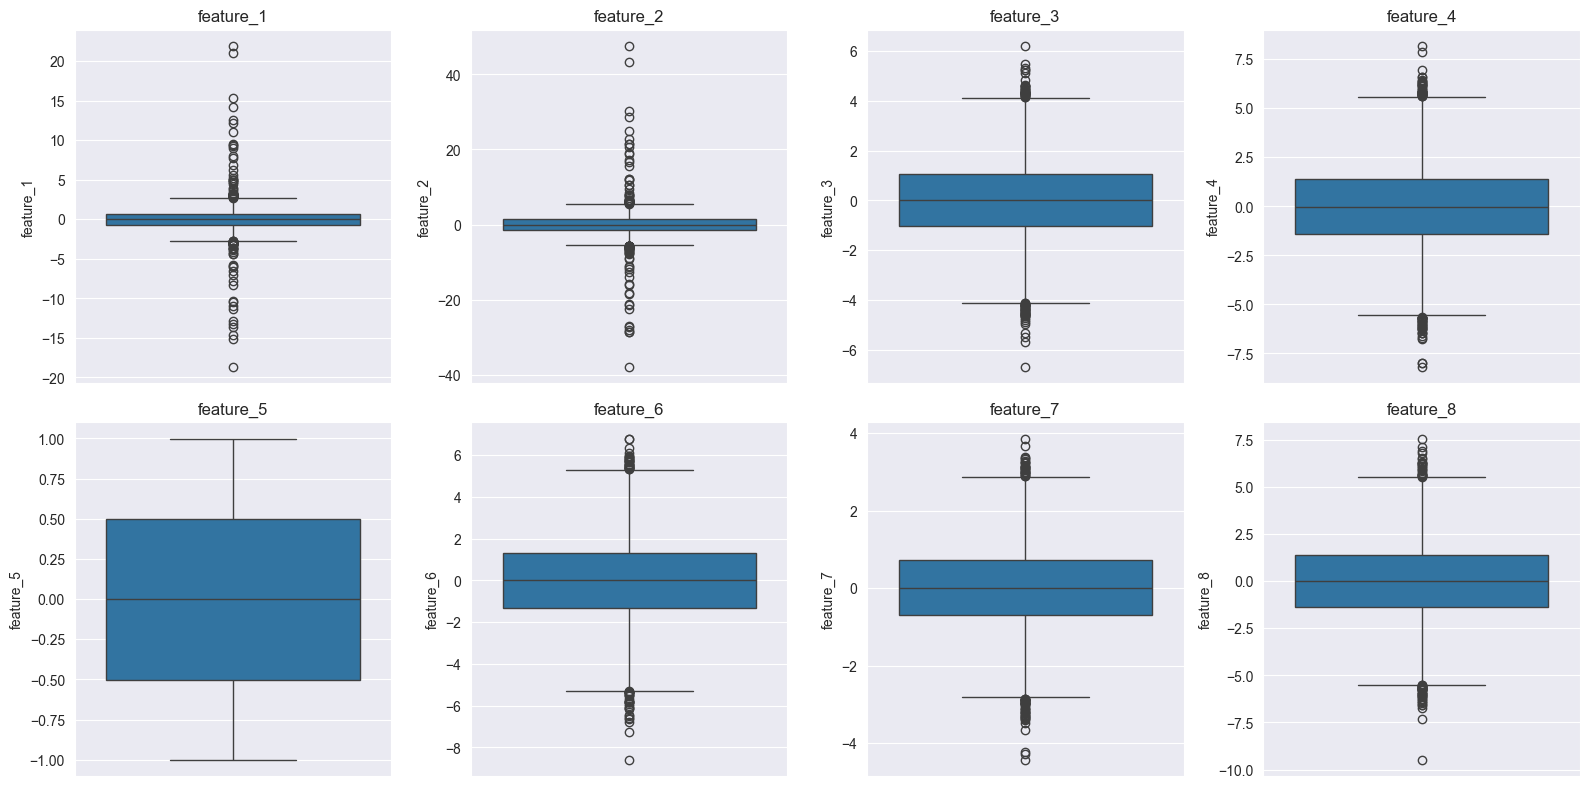

In [6]:
plt.figure(figsize=(16, 8))
for i, col in enumerate(num_features):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

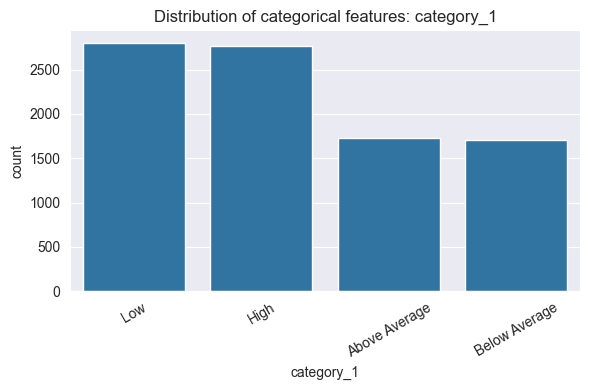

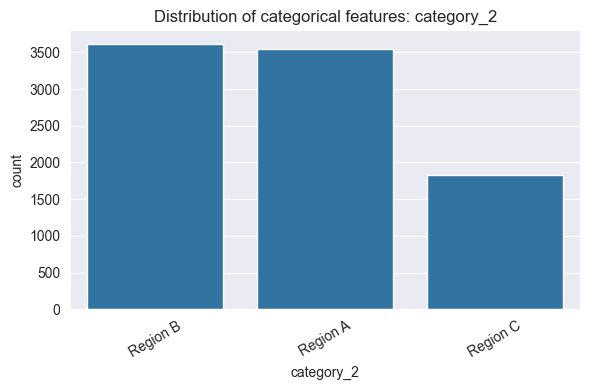

In [7]:
categorical_features = data.select_dtypes(include='object').columns.tolist()

for col in categorical_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=data, x=col, order=data[col].value_counts().index)
    plt.title(f"Distribution of categorical features: {col}")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


#### 1.3:Correlation Matrix

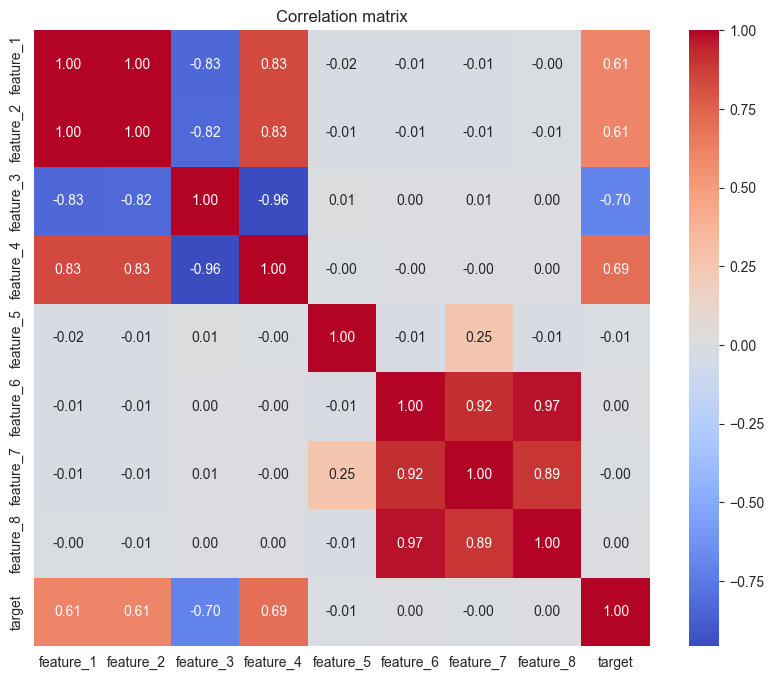

In [8]:
plt.figure(figsize=(10, 8))
corr_matrix = data[num_features + ["target"]].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation matrix")
plt.show()


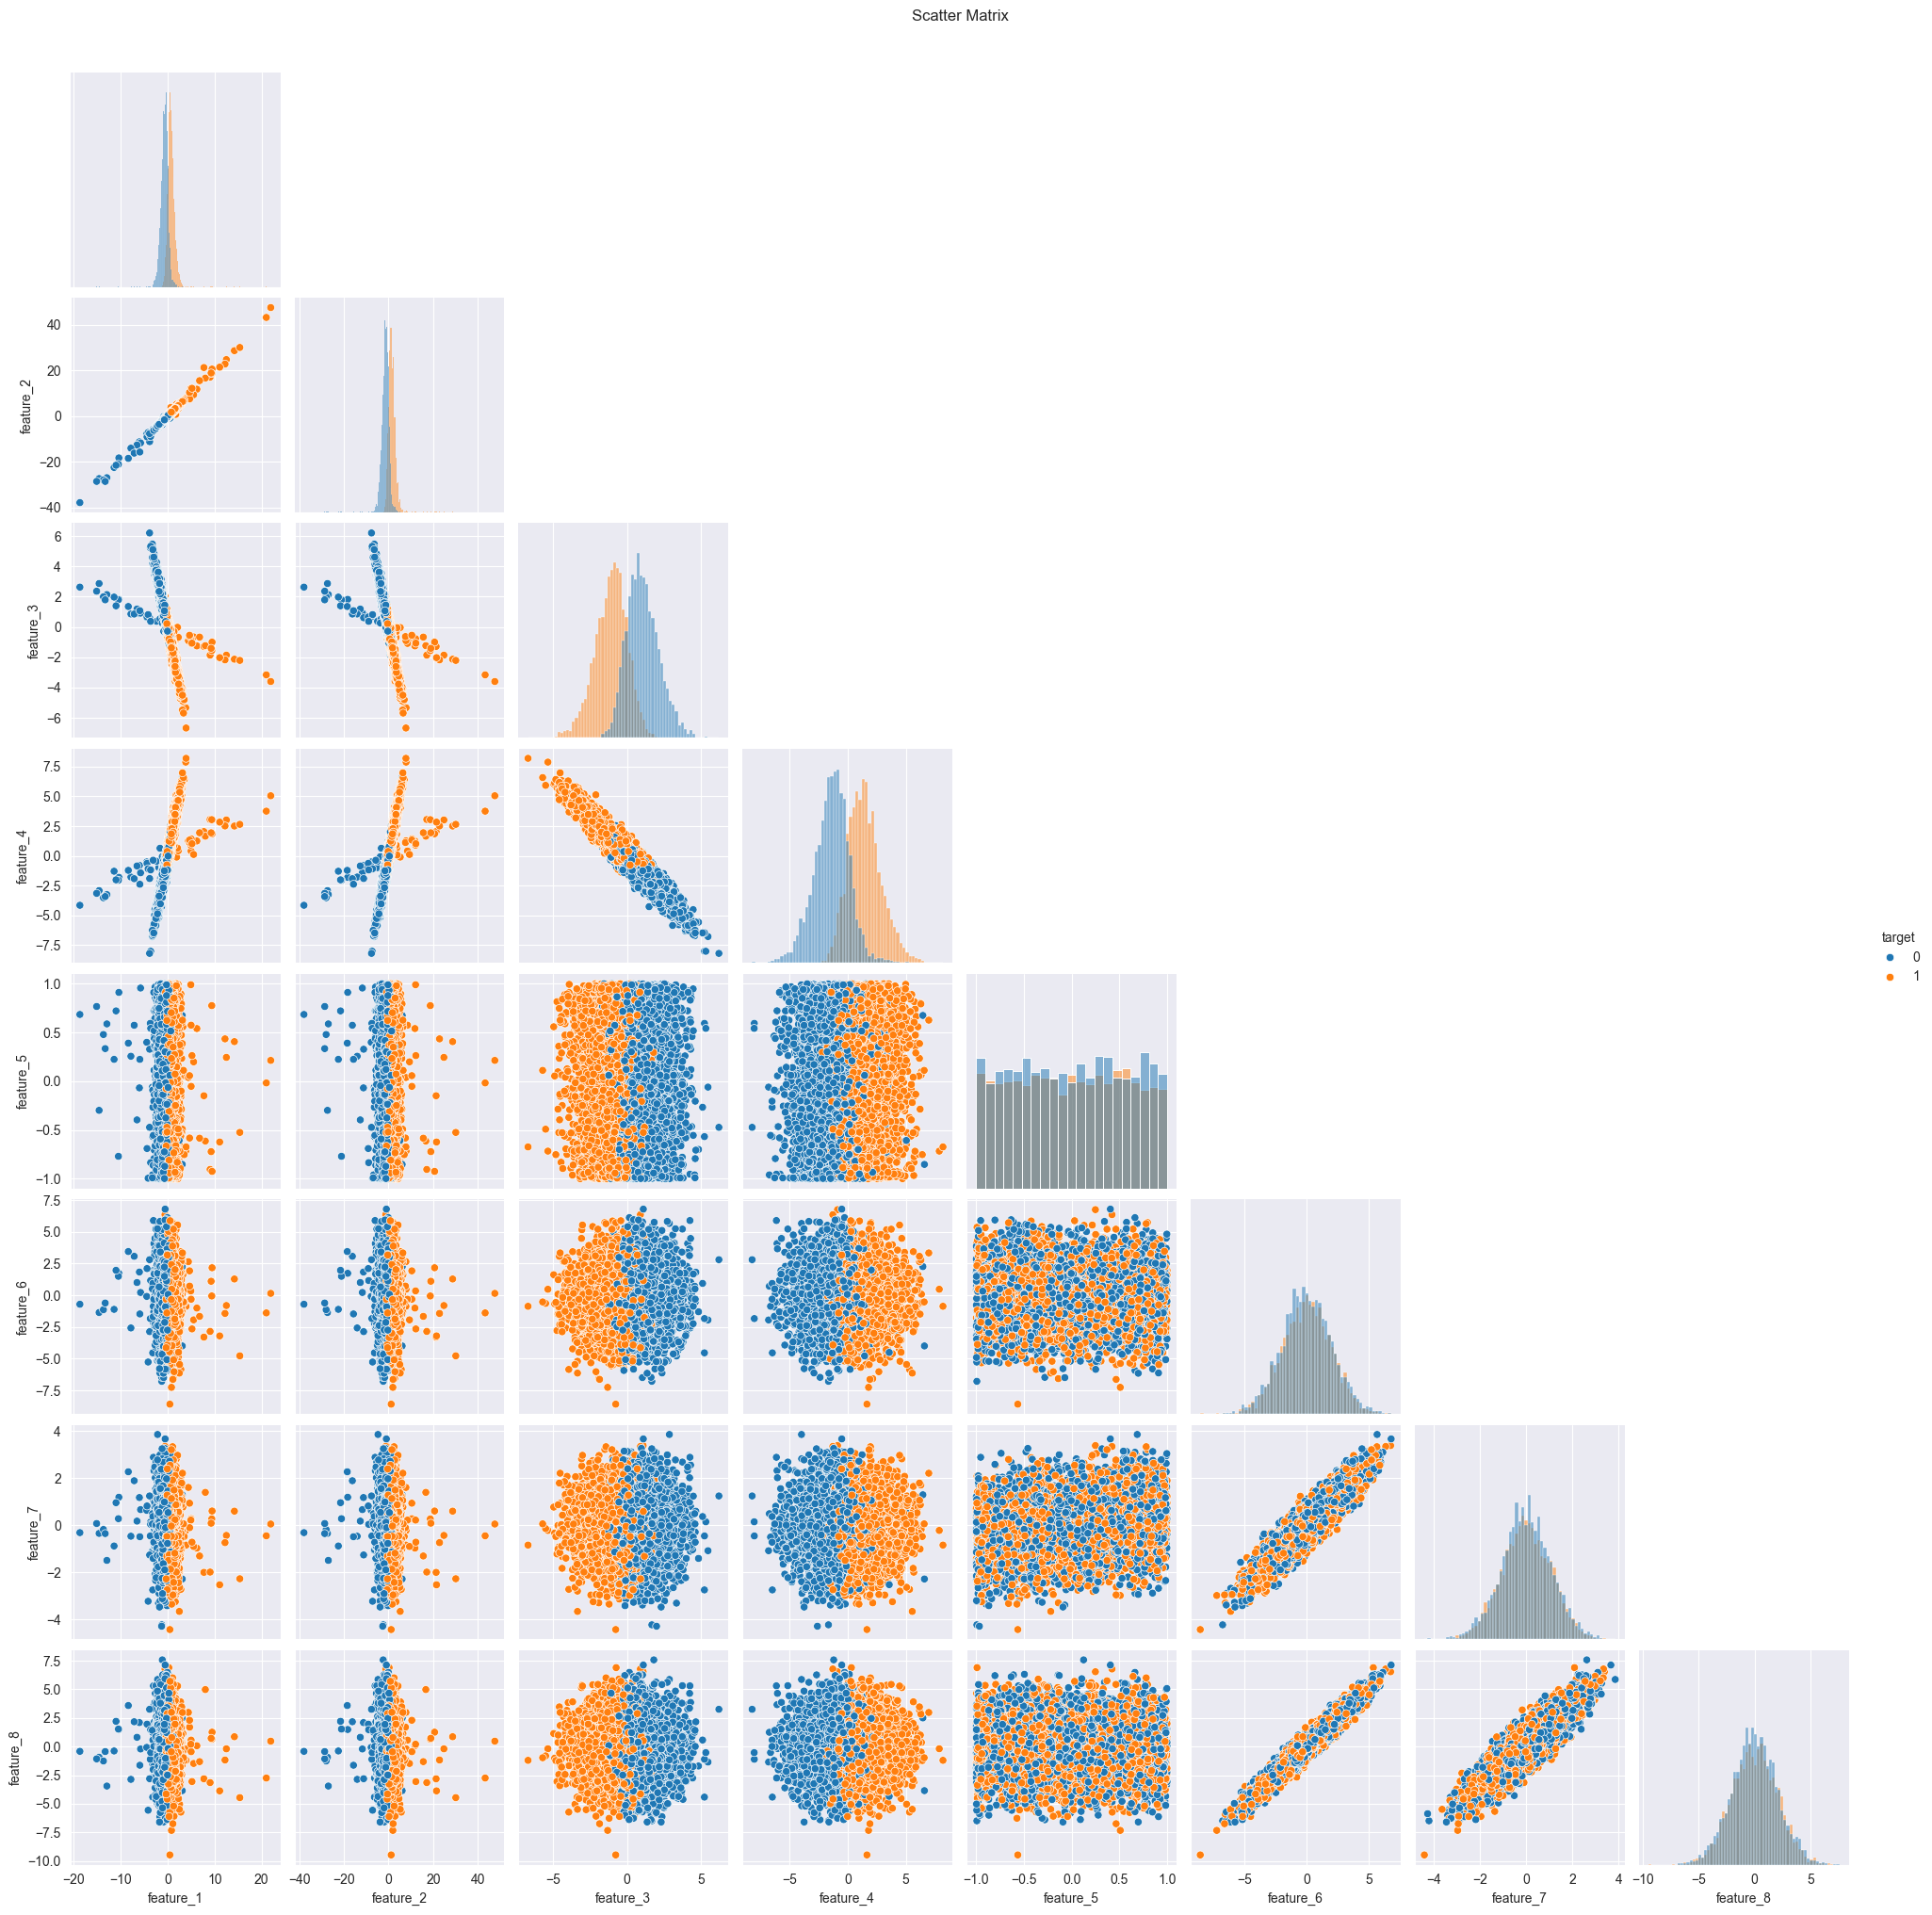

In [9]:
sns.pairplot(data[num_features + ['target']], hue="target", diag_kind="hist", corner=True)
plt.suptitle("Scatter Matrix", y=1.02)
plt.show()


### Part 2.0: 
#### Data Preprocessing

In [10]:
target_col = 'target'

#### 2.1: Remove outliers

In [11]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        if df_clean[col].dtype in ['float64', 'int64']:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

data_cleaned = remove_outliers_iqr(data, num_features)

In [12]:
# Save the cleaned dataset for submission (deliverable D2.2)
data_cleaned.to_csv('data_cleaned.csv', index=False)

#### 2.2: Show cleaning results

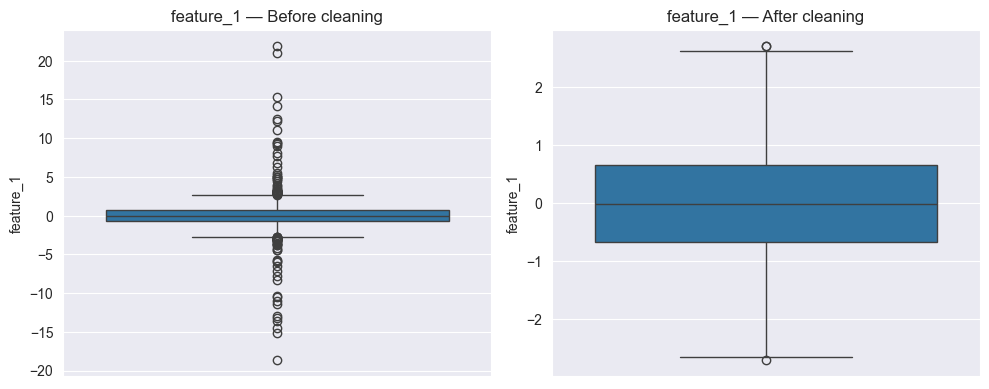

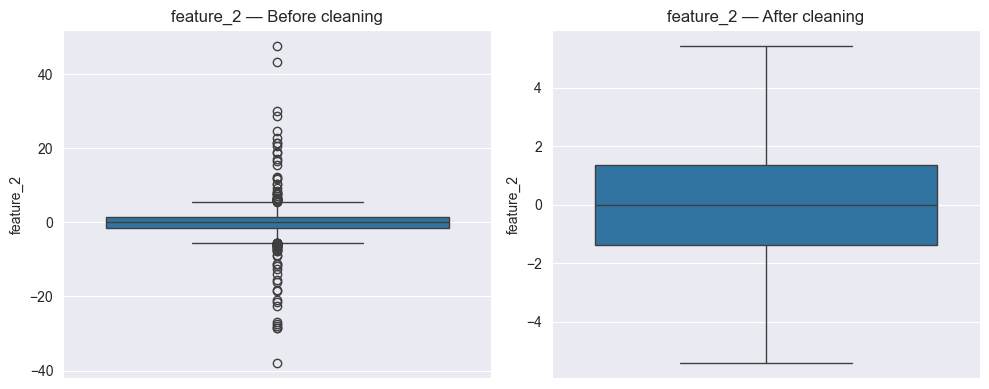

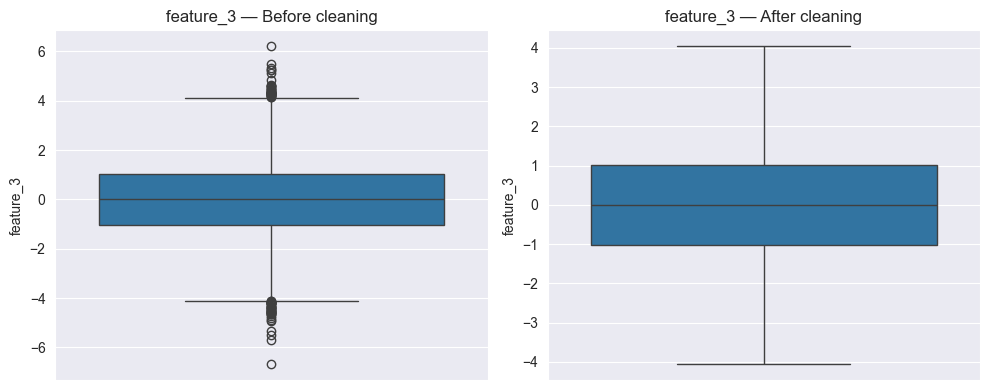

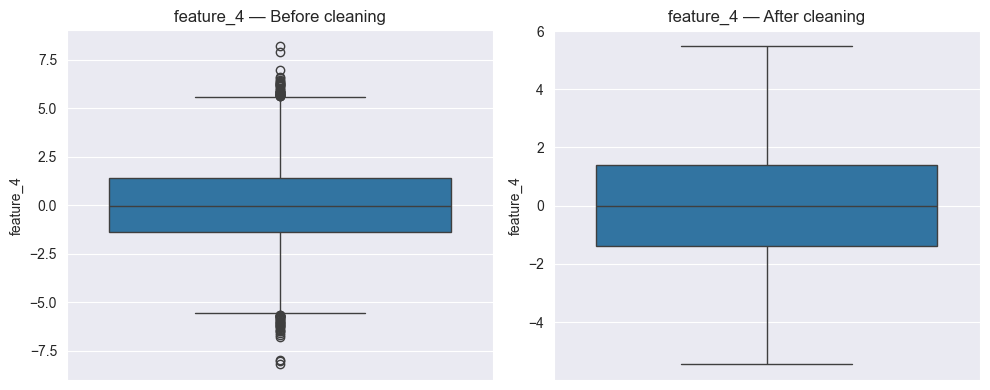

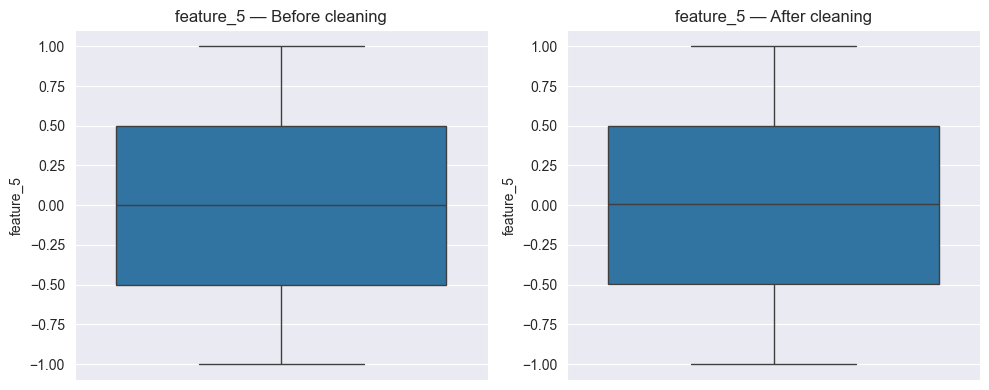

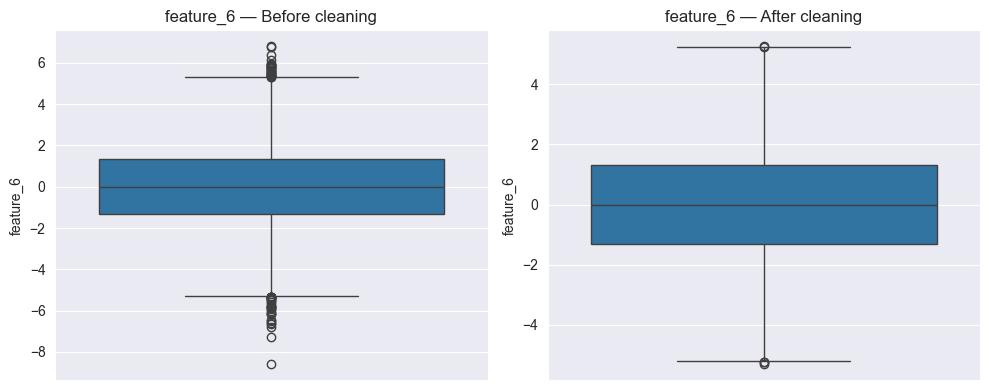

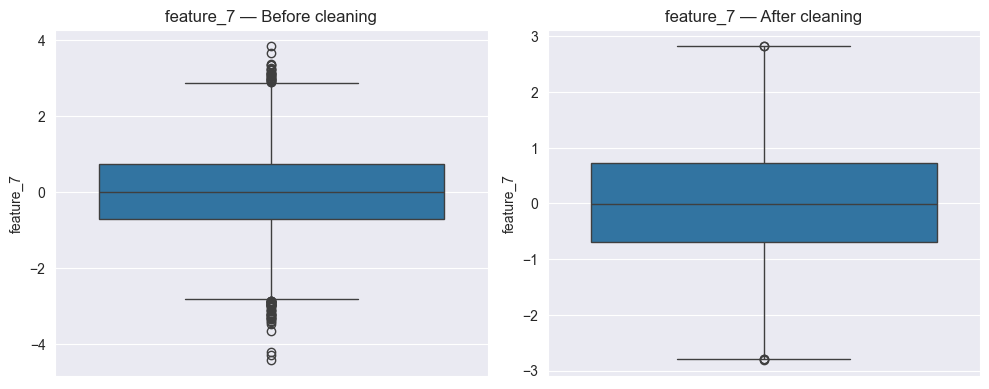

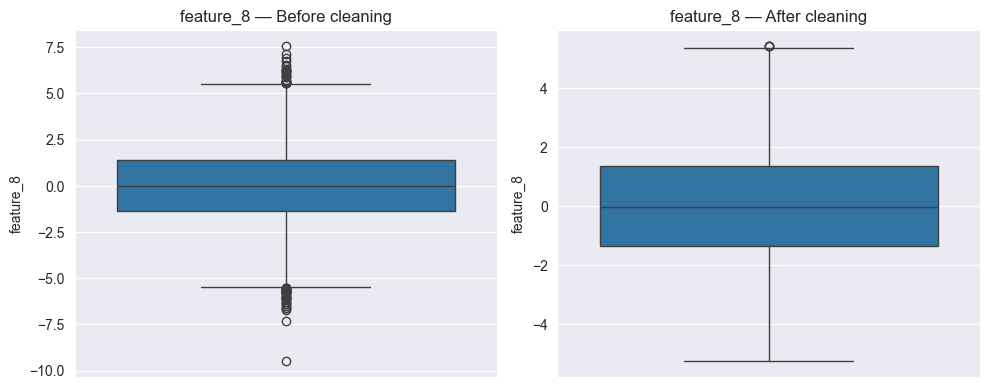

In [13]:
for col in num_features:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.boxplot(y=data[col], ax=axes[0])
    axes[0].set_title(f'{col} — Before cleaning')
    sns.boxplot(y=data_cleaned[col], ax=axes[1])
    axes[1].set_title(f'{col} — After cleaning')
    plt.tight_layout()
    plt.show()

#### 2.3: Split data

In [14]:
X = data_cleaned.drop(columns=[target_col])
y = data_cleaned[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 2.4: Preprocessing pipelines

In [15]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, num_features),
    ('cat', categorical_transformer, categorical_features)
])

In [16]:
# X_train_prepared = preprocessor.fit_transform(X_train)
# X_test_prepared = preprocessor.transform(X_test)

### Part 3.0:
### Exploratory Data Analysis (EDA)

#### 3.1: Target distribution

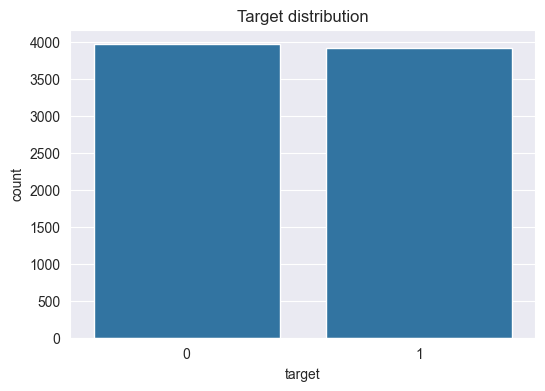

In [17]:
plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=data_cleaned)
plt.title("Target distribution")
plt.show()

#### 3.2: Correlation matrix

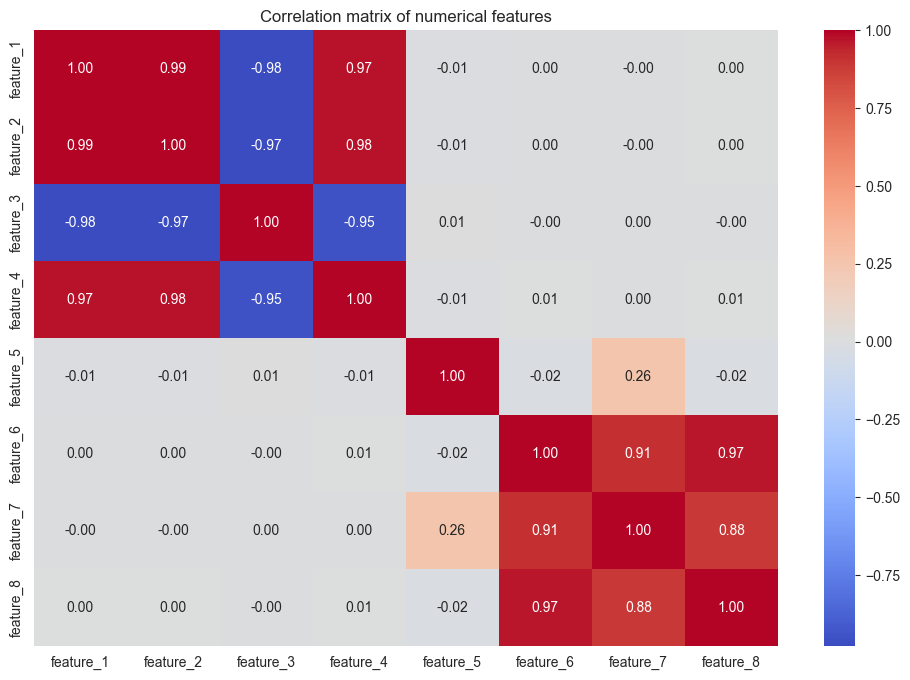

In [18]:
plt.figure(figsize=(12, 8))
corr = data_cleaned[num_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix of numerical features")
plt.show()

#### 3.3: Univariate and Bivariate Analysis with Target Variable

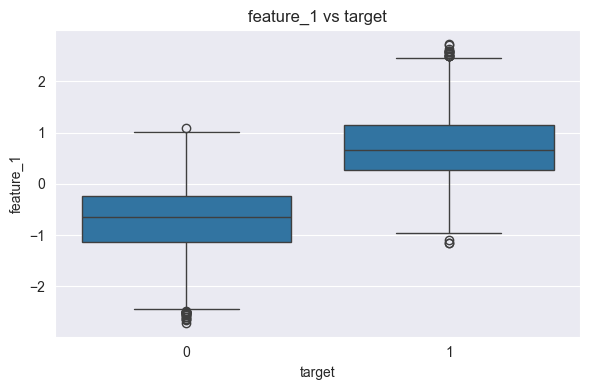

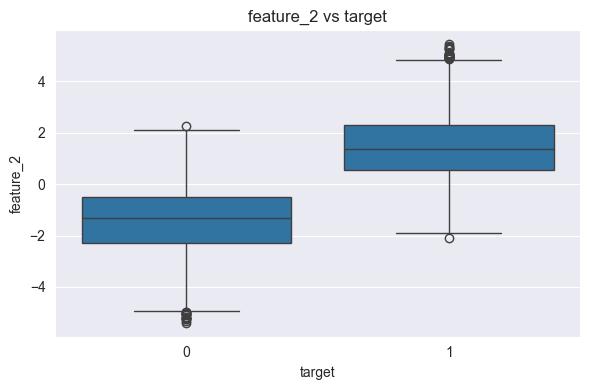

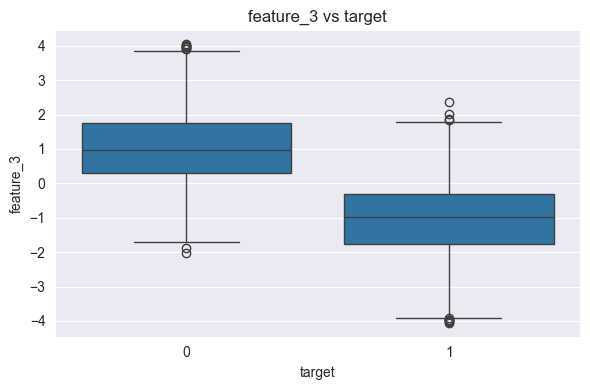

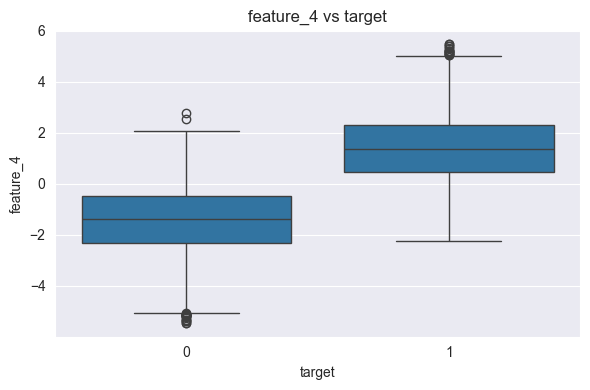

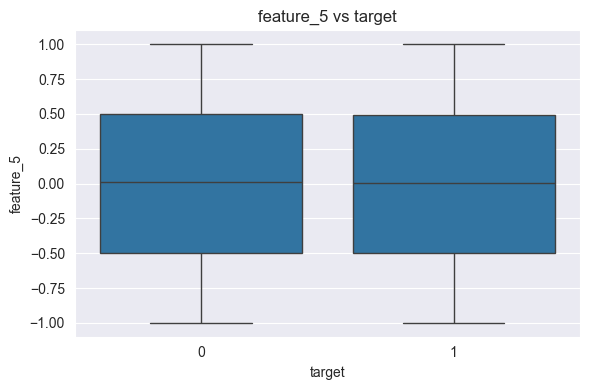

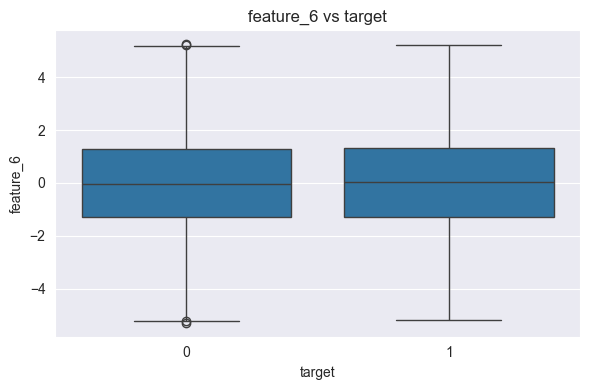

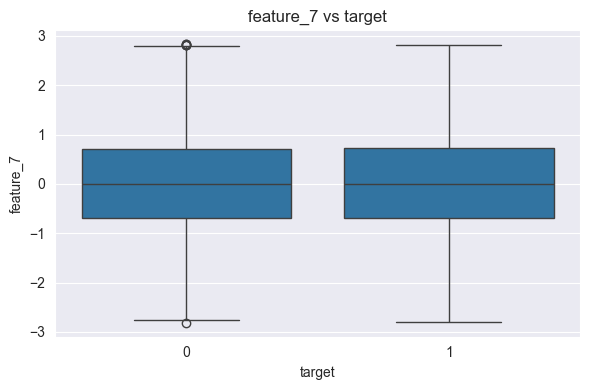

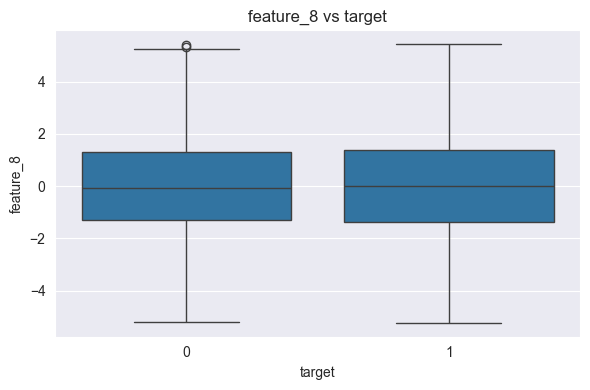

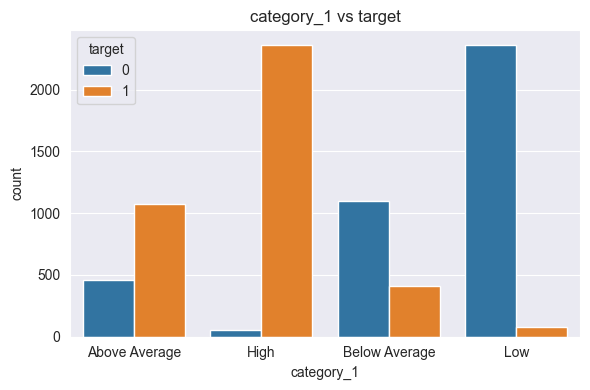

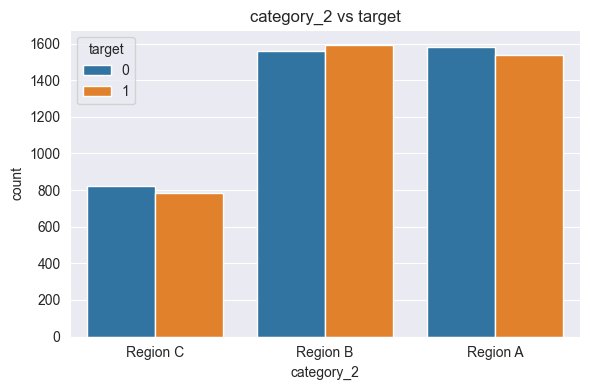

In [19]:
for col in num_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=target_col, y=col, data=data_cleaned)
    plt.title(f'{col} vs {target_col}')
    plt.tight_layout()
    plt.show()
for col in categorical_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue=target_col, data=data_cleaned)
    plt.title(f'{col} vs {target_col}')
    plt.tight_layout()
    plt.show()

#### 3.4: Statistical tests

In [20]:
from scipy.stats import ttest_ind, chi2_contingency
if data_cleaned[target_col].nunique() == 2:
    for col in num_features:
        group1 = data_cleaned[data_cleaned[target_col] == data_cleaned[target_col].unique()[0]][col]
        group2 = data_cleaned[data_cleaned[target_col] == data_cleaned[target_col].unique()[1]][col]
        t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit')
        print(f"T-test for {col}: p-value = {p_val:.4f} {'🔺' if p_val < 0.05 else ''}")
for col in categorical_features:
    ct = pd.crosstab(data_cleaned[col], data_cleaned[target_col])
    chi2, p, _, _ = chi2_contingency(ct)
    print(f"Chi-square test for {col}: p-value = {p:.4f} {'🔺' if p < 0.05 else ''}")

T-test for feature_1: p-value = 0.0000 🔺
T-test for feature_2: p-value = 0.0000 🔺
T-test for feature_3: p-value = 0.0000 🔺
T-test for feature_4: p-value = 0.0000 🔺
T-test for feature_5: p-value = 0.4328 
T-test for feature_6: p-value = 0.3854 
T-test for feature_7: p-value = 0.8009 
T-test for feature_8: p-value = 0.3697 
Chi-square test for category_1: p-value = 0.0000 🔺
Chi-square test for category_2: p-value = 0.4663 


### Part 4.0:
#### Feature Engineering

#### 4.1: Remove feature_2

In [21]:
data_cleaned.drop(columns=['feature_2'], inplace=True)

#### 4.1: PCA for feature_6, feature_7, feature_8

In [22]:
pca_features = ['feature_6', 'feature_7', 'feature_8']
pca = PCA(n_components=1)
data_cleaned['feature_6_7_8_pca'] = pca.fit_transform(data_cleaned[pca_features])
data_cleaned.drop(columns=pca_features, inplace=True)


#### 4.2: Update feature lists

In [23]:
num_features = data_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_features.remove('target')
categorical_features = data_cleaned.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

In [24]:
print("Updated numerical features:", num_features)
print("Updated categorical features:", categorical_features)

Updated numerical features: ['feature_1', 'feature_3', 'feature_4', 'feature_5', 'feature_6_7_8_pca']
Updated categorical features: ['category_1', 'category_2']


In [25]:
# Save dataset after feature engineering (cleaned + engineered)
data_cleaned.to_csv("data_features_engineered.csv", index=False)
print("Feature-engineered dataset saved.")

Feature-engineered dataset saved.


#### 4.3: Show updated correlation matrix

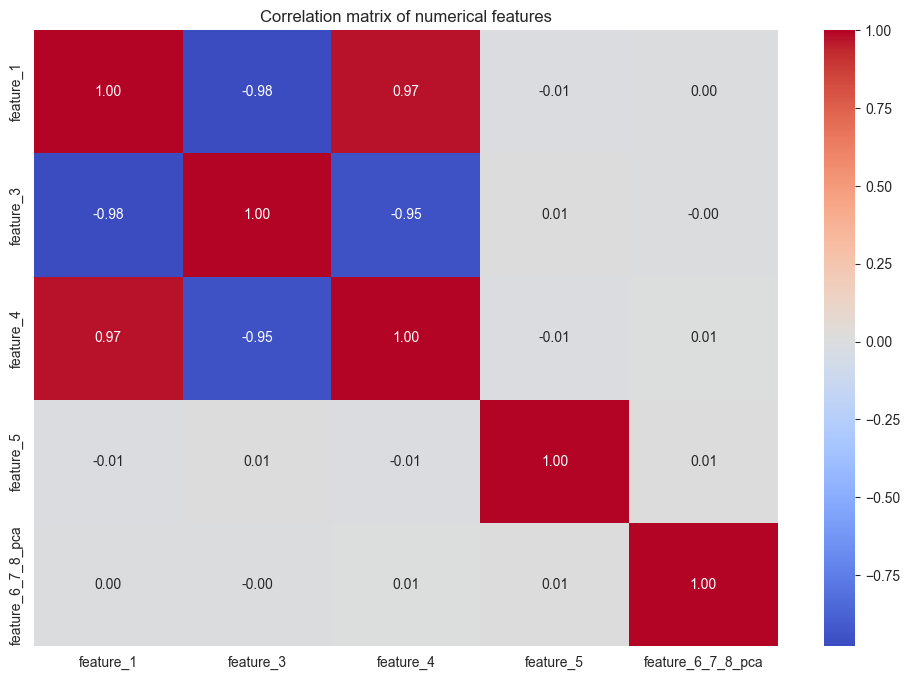

In [26]:
plt.figure(figsize=(12, 8))
corr = data_cleaned[num_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix of numerical features")
plt.show()

#### 4.4: Update X and y after feature engineering

In [27]:
X = data_cleaned.drop(columns=[target_col])
y = data_cleaned[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [28]:

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, num_features),
    ('cat', categorical_transformer, categorical_features)
])

### Part 5.0
### Modeling

#### 5.1: Initialize models

In [29]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,verbosity=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

#### 5.2: Cross-validation evaluation

In [30]:
results = []

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    acc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy')
    f1 = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='f1')
    roc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc')

    results.append({
        'Model': name,
        'Accuracy Mean': acc.mean(),
        'F1 Score Mean': f1.mean(),
        'ROC AUC Mean': roc.mean()
    })

#### 5.3: Add voting classifier

In [31]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', models["Logistic Regression"]),
        ('rf', models["Random Forest"]),
        ('xgb', models["XGBoost"])
    ],
    voting='soft'
)

voting_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', voting_clf)
])

acc = cross_val_score(voting_pipe, X_train, y_train, cv=cv, scoring='accuracy')
f1 = cross_val_score(voting_pipe, X_train, y_train, cv=cv, scoring='f1')
roc = cross_val_score(voting_pipe, X_train, y_train, cv=cv, scoring='roc_auc')

results.append({
    'Model': 'Voting Ensemble',
    'Accuracy Mean': acc.mean(),
    'F1 Score Mean': f1.mean(),
    'ROC AUC Mean': roc.mean()
})


#### 5.4: The results

In [32]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='ROC AUC Mean', ascending=False)
print(results_df)



                 Model  Accuracy Mean  F1 Score Mean  ROC AUC Mean
0  Logistic Regression       0.876589       0.874489      0.954442
3    Gradient Boosting       0.871512       0.868374      0.951550
4      Voting Ensemble       0.871038       0.868254      0.950447
1        Random Forest       0.867388       0.863756      0.946650
2              XGBoost       0.861995       0.859135      0.941455


In [33]:
import os
import joblib


used_model_keys = ["Logistic Regression", "Random Forest", "Gradient Boosting"]

os.makedirs('models', exist_ok=True)

for name in used_model_keys:
    print(f"Training and saving model: {name}")
    model = models[name]
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    filename = f"models/{name.lower().replace(' ', '_')}_model.pkl"
    joblib.dump(pipe, filename)

voting_pipe.fit(X_train, y_train)
joblib.dump(voting_pipe, 'models/voting_ensemble_model.pkl')


Training and saving model: Logistic Regression
Training and saving model: Random Forest
Training and saving model: Gradient Boosting


['models/voting_ensemble_model.pkl']

#### 5.5: Visualize model performance

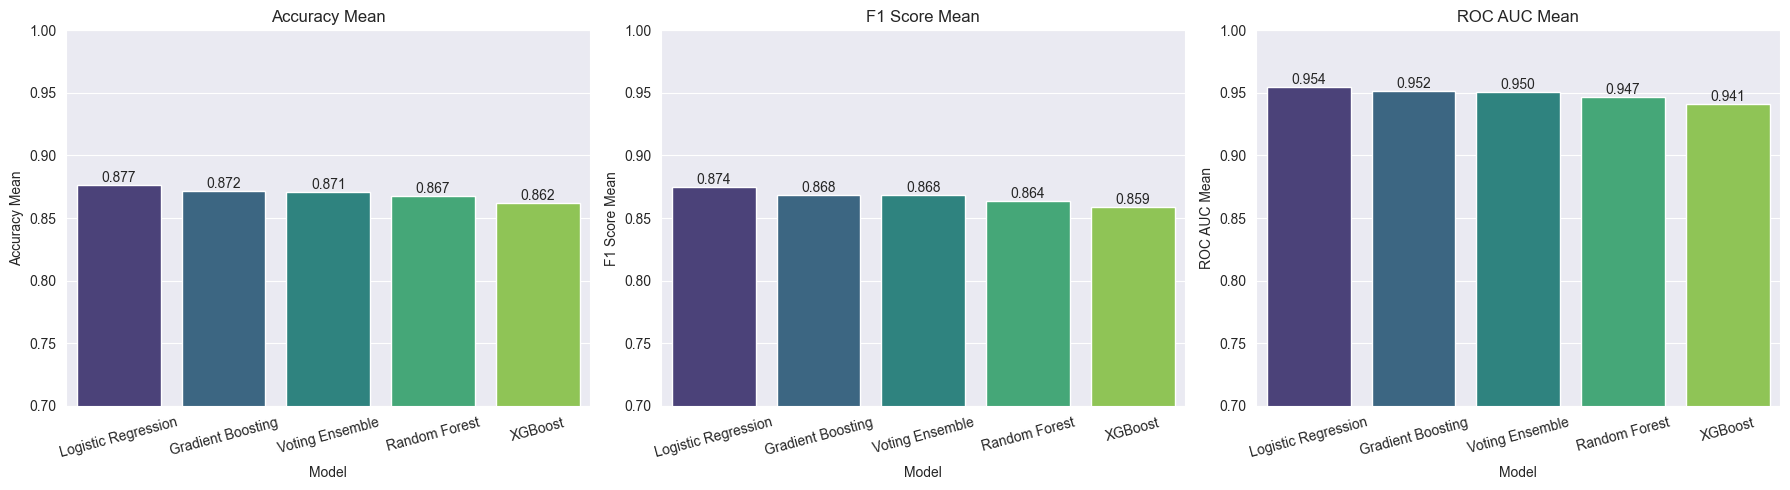

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
metrics = ["Accuracy Mean", "F1 Score Mean", "ROC AUC Mean"]
colors = sns.color_palette("viridis", len(results_df))

for i, metric in enumerate(metrics):
    sns.barplot(x="Model", y=metric, hue="Model", data=results_df, ax=axs[i], palette=colors, legend=False)
    axs[i].set_title(metric)
    axs[i].set_ylim(0.7, 1)
    axs[i].tick_params(axis='x', rotation=15)
    for container in axs[i].containers:
        axs[i].bar_label(container, fmt='%.3f', label_type='edge')

plt.tight_layout()
plt.show()


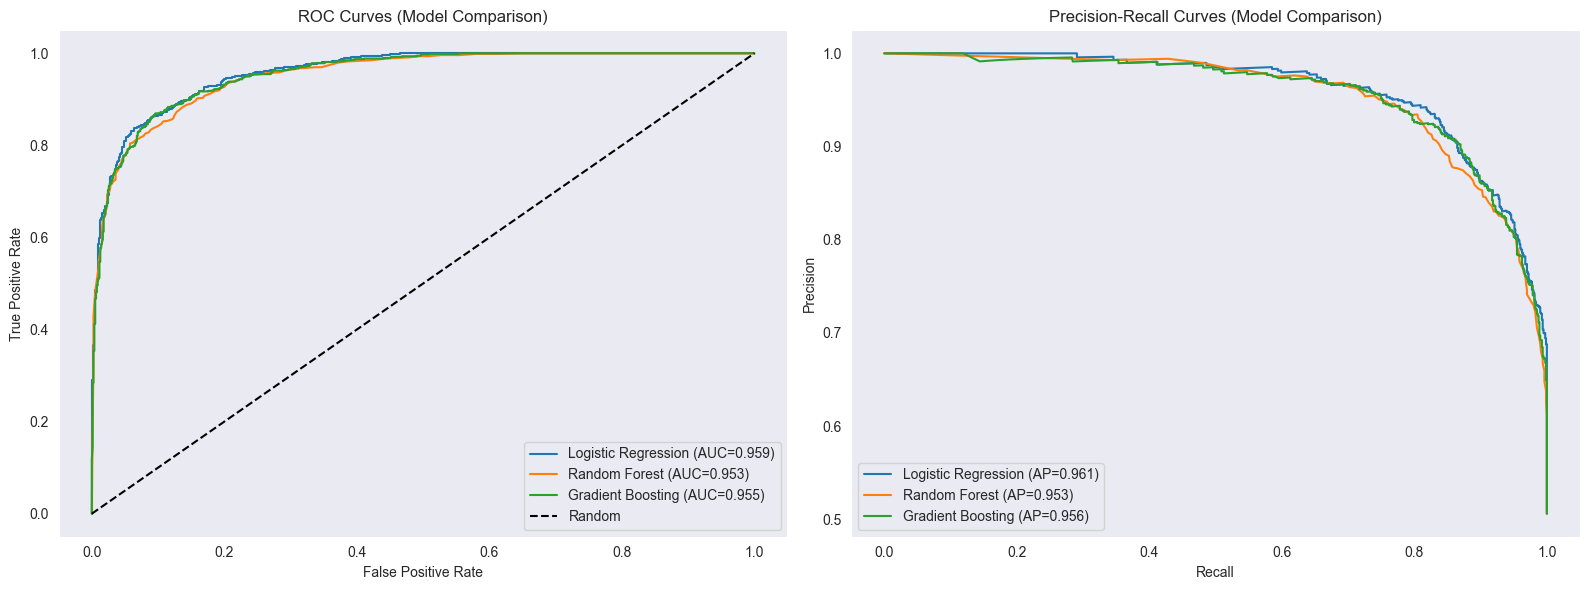

In [47]:
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve

selected_models = ["Logistic Regression", "Random Forest", "Gradient Boosting"]
fitted_pipes = {}


plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
for name in selected_models:
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', models[name])
    ])
    pipe.fit(X_train, y_train)
    fitted_pipes[name] = pipe
    y_probs = pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Model Comparison)')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
for name in selected_models:
    y_probs = fitted_pipes[name].predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    ap = average_precision_score(y_test, y_probs)
    plt.plot(recall, precision, label=f'{name} (AP={ap:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (Model Comparison)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()




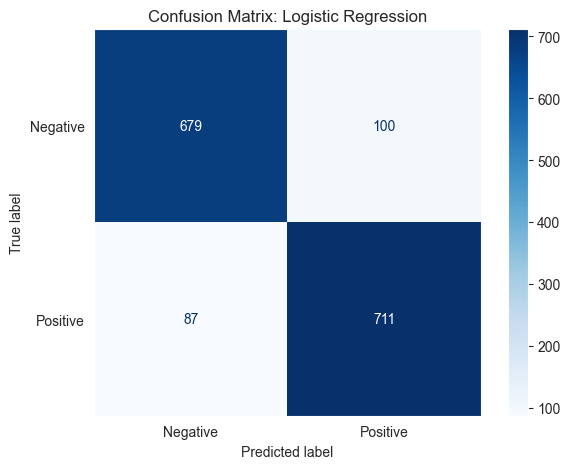

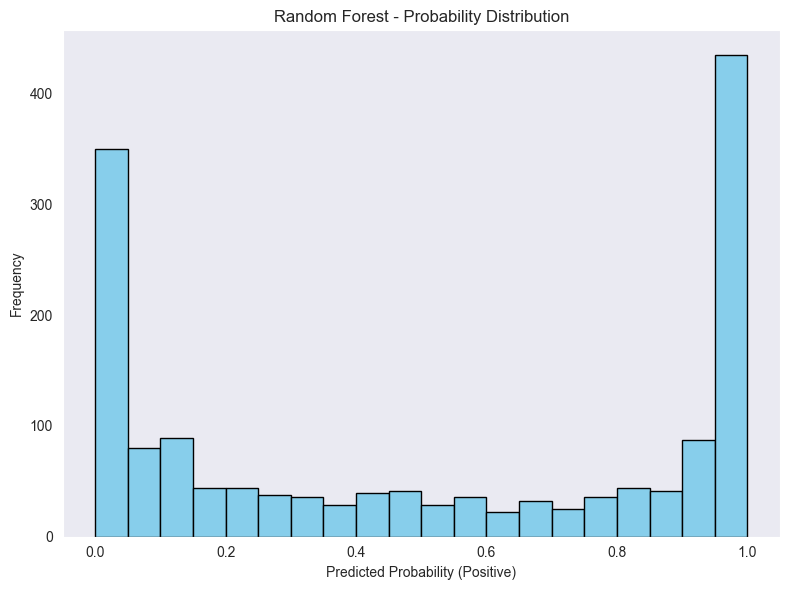

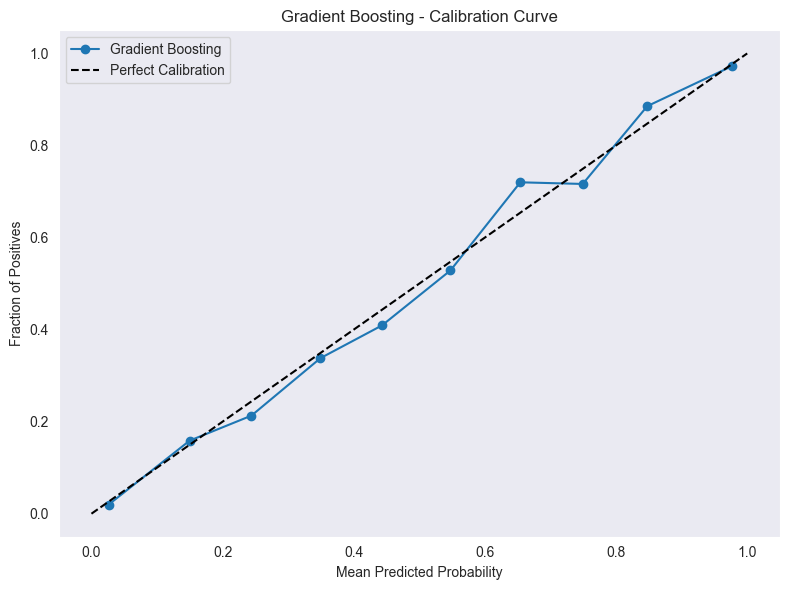

In [48]:
# 🔹 Logistic Regression: Confusion Matrix
lr_pipe = fitted_pipes['Logistic Regression']
y_pred_lr = lr_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Logistic Regression')
plt.grid(False)
plt.tight_layout()
plt.show()

# 🔹 Random Forest: Histogram of Prediction Probabilities
rf_pipe = fitted_pipes['Random Forest']
y_probs_rf = rf_pipe.predict_proba(X_test)[:, 1]
plt.figure(figsize=(8, 6))
plt.hist(y_probs_rf, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Predicted Probability (Positive)')
plt.ylabel('Frequency')
plt.title('Random Forest - Probability Distribution')
plt.grid()
plt.tight_layout()
plt.show()

# 🔹 Gradient Boosting: Calibration Plot
gb_pipe = fitted_pipes['Gradient Boosting']
y_probs_gb = gb_pipe.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, y_probs_gb, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Gradient Boosting')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Gradient Boosting - Calibration Curve')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Part 6.0:
### Model Hyperparameter Tuning

#### 6.1: Define hyperparameter grids for each model

In [36]:

param_grids = {
    'Logistic Regression': {
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['liblinear']
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.05, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5]
    }
}



#### 6.2: Initialize base models

In [37]:

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

#### 6.3: Perform grid search for each model

In [38]:
tuning_results = []
best_models = {}

for name, model in models.items():
    print(f"Tuning: {name}")
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    grid = GridSearchCV(pipe, param_grids[name], cv=cv, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    if name == 'Logistic Regression':
        grid_lr = grid

    best_models[name] = grid.best_estimator_

    test_roc_auc = roc_auc_score(y_test, grid.predict_proba(X_test)[:, 1])

    tuning_results.append({
        'Model': name,
        'Best ROC AUC': test_roc_auc,
        'Best Params': grid.best_params_
    })

Tuning: Logistic Regression
Tuning: Gradient Boosting
Tuning: Random Forest


KeyboardInterrupt: 

#### 6.4: Display tuning results 

In [46]:
tuning_df = pd.DataFrame(tuning_results)
tuning_df = tuning_df.sort_values(by='Best ROC AUC', ascending=False)
print("\nTUNING RESULTS SUMMARY:")
print("="*40)
print(tuning_df)


TUNING RESULTS SUMMARY:
                 Model  Best ROC AUC  \
0  Logistic Regression      0.959406   
1    Gradient Boosting      0.956148   
2        Random Forest      0.955105   

                                         Best Params  
0  {'classifier__C': 1, 'classifier__penalty': 'l...  
1  {'classifier__learning_rate': 0.05, 'classifie...  
2  {'classifier__max_depth': 10, 'classifier__min...  


Saving best-tuned models.

In [47]:
import os
import joblib

os.makedirs('best_models', exist_ok=True)

for name, model in best_models.items():
    filename = f"best_models/{name.lower().replace(' ', '_')}_best.pkl"
    joblib.dump(model, filename)
    print(f"Saved: {filename}")


Saved: best_models/logistic_regression_best.pkl
Saved: best_models/gradient_boosting_best.pkl
Saved: best_models/random_forest_best.pkl


#### 6.4.1: Preparation of data for comparison plot

In [48]:

results_df_trimmed = results_df[results_df['Model'].isin(tuning_df['Model'])].copy()
results_df_trimmed = results_df_trimmed.rename(columns={'ROC AUC Mean': 'ROC AUC'})
results_df_trimmed['Type'] = 'Before Tuning'

tuning_plot_df = tuning_df[['Model', 'Best ROC AUC']].copy()
tuning_plot_df = tuning_plot_df.rename(columns={'Best ROC AUC': 'ROC AUC'})
tuning_plot_df['Type'] = 'After Tuning'

combined_df = pd.concat([results_df_trimmed[['Model', 'ROC AUC', 'Type']], tuning_plot_df])


#### 6.4.2: Create comparison plot

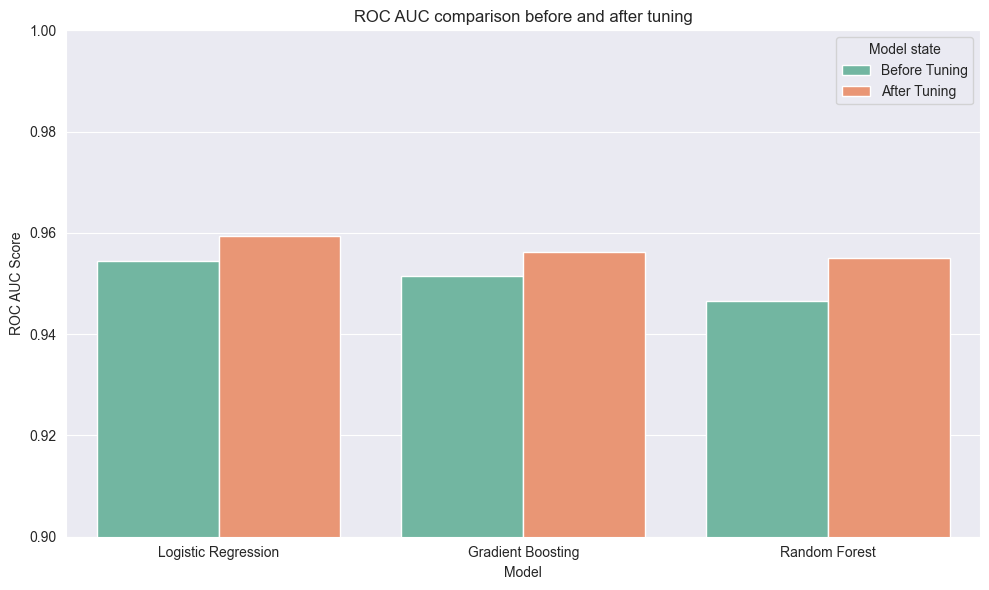

In [49]:

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='ROC AUC', hue='Type', data=combined_df, palette='Set2')
plt.title('ROC AUC comparison before and after tuning')
plt.ylim(0.9, 1.0)
plt.ylabel('ROC AUC Score')
plt.xlabel('Model')
plt.legend(title='Model state')
plt.tight_layout()
plt.show()


### 7.0:
### Model Interpretation

#### 7.1: Train models for feature importance analysis

In [50]:

lr_model = best_models['Logistic Regression']
gb_model = best_models['Gradient Boosting']
rf_model = best_models['Random Forest']



rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['feature_1', 'feature_3',
                                                   'feature_4', 'feature_5',
                                                   'feature_6_7_8_pca']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['category_1',
                                                   'category_2'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=5,
                                        n_estimators=200, random_state=42))])

In [94]:
lr_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['feature_1', 'feature_3',
                                                   'feature_4', 'feature_5',
                                                   'feature_6_7_8_pca']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['category_1',
                                                   'category_2'])])),
                ('classifier',
                 LogisticRegression(C=1, max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [95]:
gb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['feature_1', 'feature_3',
                                                   'feature_4', 'feature_5',
                                                   'feature_6_7_8_pca']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['category_1',
                                                   'category_2'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            random_state=42))])

#### 7.2: Working with features

In [96]:

feature_names = gb_model.named_steps['preprocessor'].get_feature_names_out()

gb_importances = gb_model.named_steps['classifier'].feature_importances_

rf_importances = rf_model.named_steps['classifier'].feature_importances_

lr_coefs = lr_model.named_steps['classifier'].coef_[0]
lr_importances = np.abs(lr_coefs)

#### 7.3: Get top 15 features for each model

In [97]:
# Gradient Boosting
gb_df = pd.DataFrame({'Feature': feature_names, 'Importance': gb_importances})
gb_df_sorted = gb_df.sort_values(by='Importance', ascending=False).head(15)

# Random Forest
rf_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
rf_df_sorted = rf_df.sort_values(by='Importance', ascending=False).head(15)

# Logistic Regression
lr_df = pd.DataFrame({'Feature': feature_names, 'Importance': lr_importances})
lr_df_sorted = lr_df.sort_values(by='Importance', ascending=False).head(15)


#### 7.4: Plot feature importance comparison

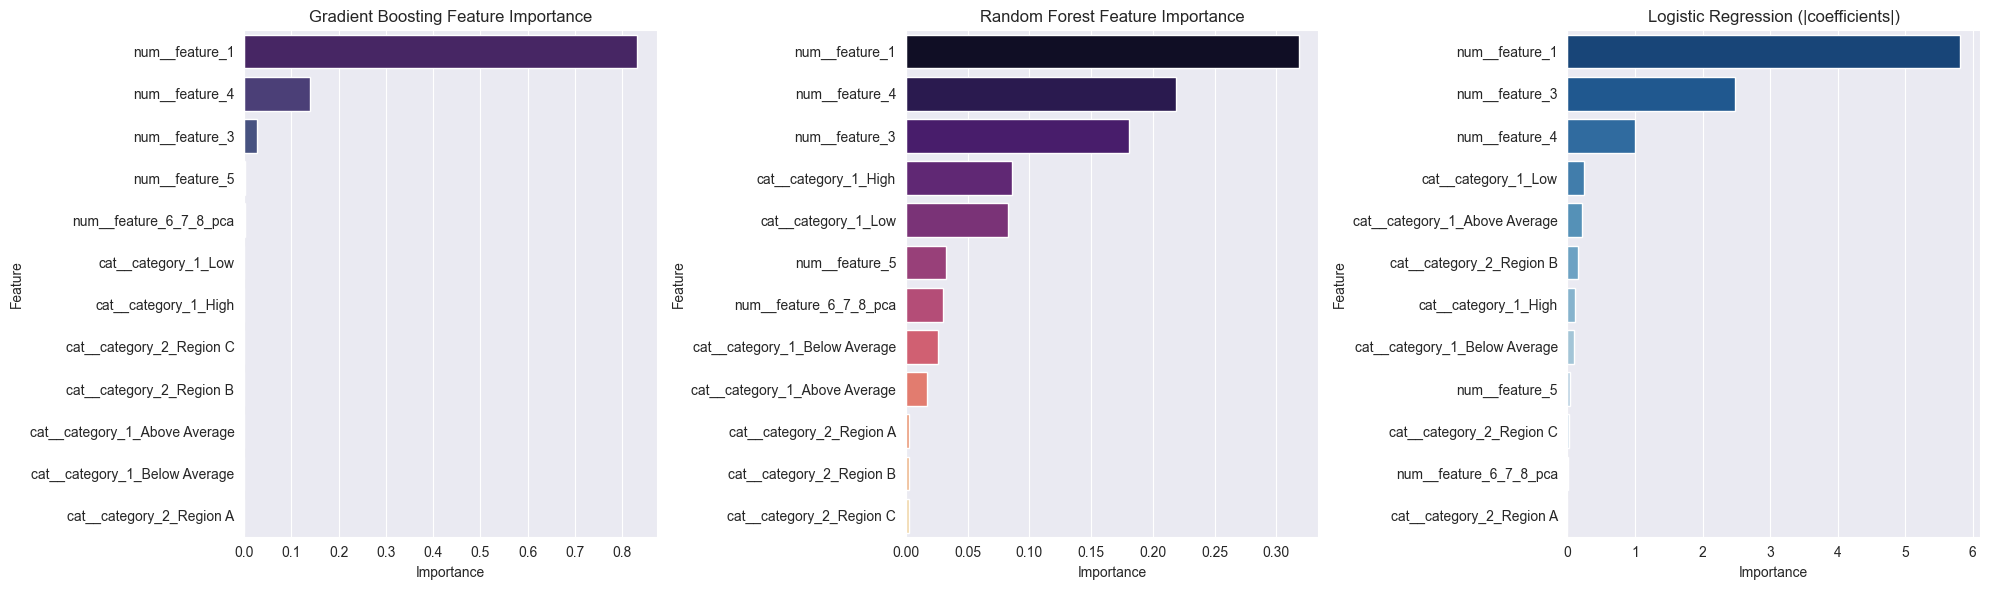

In [98]:
plt.figure(figsize=(20, 6))

# Gradient Boosting
plt.subplot(1, 3, 1)
sns.barplot(data=gb_df_sorted, y='Feature', x='Importance', palette='viridis', hue='Feature', legend=False)
plt.title('Gradient Boosting Feature Importance')

# Random Forest
plt.subplot(1, 3, 2)
sns.barplot(data=rf_df_sorted, y='Feature', x='Importance', palette='magma', hue='Feature', legend=False)
plt.title('Random Forest Feature Importance')

# Logistic Regression
plt.subplot(1, 3, 3)
sns.barplot(data=lr_df_sorted, y='Feature', x='Importance', palette='Blues_r', hue='Feature', legend=False)
plt.title('Logistic Regression (|coefficients|)')

plt.tight_layout()
plt.show()


In Logistic Regression, feature importance is computed using the absolute value of the model coefficients (|β|).
Unlike tree-based models where importances are normalized to sum to 1, these coefficients reflect the linear impact of each feature on the predicted log-odds.
As a result, the importance scale in Logistic Regression is not directly comparable to that of Gradient Boosting or Random Forest.

### Part 8.0: 
### Shap values

In [87]:
print("\nCALCULATING SHAP VALUES FOR MODEL INTERPRETATION")
print("="*40)



CALCULATING SHAP VALUES FOR MODEL INTERPRETATION


#### 8.1: Prepare transformed data for SHAP analysis

In [88]:
print("\nPreprocessing data for SHAP analysis...")
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


Preprocessing data for SHAP analysis...


#### 8.2: SHAP analysis for Logistic Regression


Calculating SHAP values for Logistic Regression...


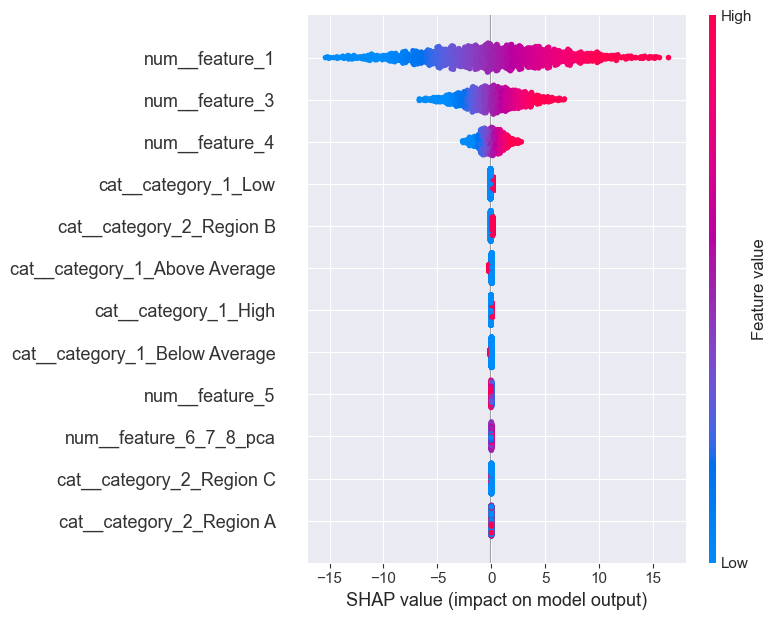

In [100]:
print("\nCalculating SHAP values for Logistic Regression...")


lr_pipeline = best_models['Logistic Regression']
lr_model = lr_pipeline.named_steps['classifier']
feature_names = lr_pipeline.named_steps['preprocessor'].get_feature_names_out()


explainer = shap.Explainer(lr_model, X_train_transformed, feature_names=feature_names)
shap_values = explainer(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)


#### 8.3: SHAP analysis for Gradient Boosting


Calculating SHAP values for Gradient Boosting...


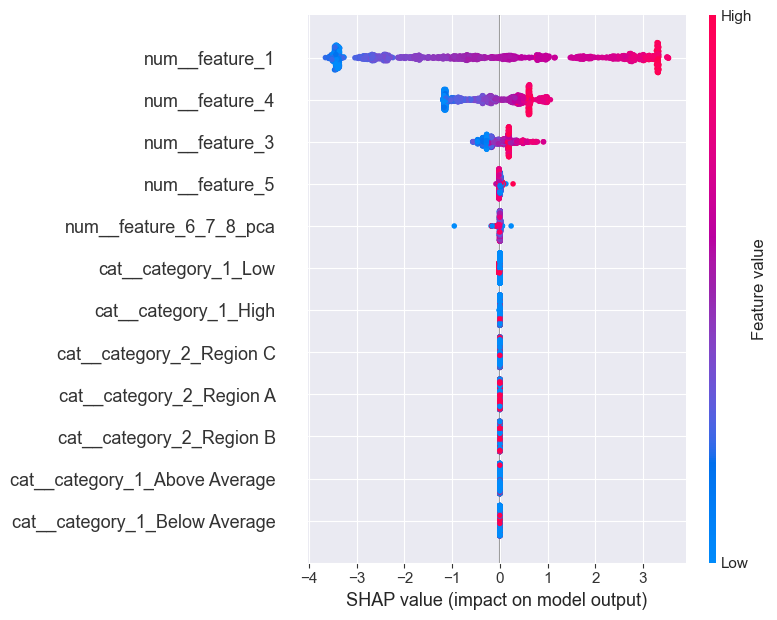


MODEL INTERPRETATION COMPLETE!


In [108]:
print("\nCalculating SHAP values for Gradient Boosting...")
best_gb = best_models['Gradient Boosting']
X_test_transformed = preprocessor.transform(X_test)
feature_names = best_gb.named_steps['preprocessor'].get_feature_names_out()
gb_model = best_gb.named_steps['classifier']
explainer = shap.Explainer(gb_model, X_test_transformed, feature_names=feature_names)
shap_values = explainer(X_test_transformed)


shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)


print("\nMODEL INTERPRETATION COMPLETE!")